<a href="https://colab.research.google.com/github/dhanushnayak/DenoiseRIDNet/blob/main/Denosing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3105675898709289263
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8620929844344831309
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [8]:
!pip install patchify
import os
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
from patchify import patchify, unpatchify
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

In [10]:
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,concatenate,Add,Multiply,Reshape,Activation,Input
from tensorflow.keras.models import Model

In [11]:
class EAM(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.conv1 = Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')
    self.conv2 = Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')
    self.conv3 = Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')
    self.conv4 = Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')
    
    self.conv5 = Conv2D(64, (3,3), padding='same',activation='relu')

    self.conv6 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv7 = Conv2D(64, (3,3),padding='same',activation='relu')

    self.conv8 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv9 =  Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv10  = Conv2D(64, (1,1),padding='same')

    self.gap = GlobalAveragePooling2D()

    self.conv11 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv12 = Conv2D(64, (3,3),padding='same',activation='sigmoid')

  def call(self,input1):
    
    conv1 = self.conv1(input1)
    conv1 = self.conv2(conv1)

    conv2 = self.conv3(input1)
    conv2 = self.conv4(conv2)

    concat = concatenate([conv1,conv2])

    conv3 = self.conv5(concat)

    add_stage_1 = Add()([input1,conv3])

    conv4 = self.conv6(add_stage_1)
    conv4 = self.conv7(conv4)

    add_stage_2 =  Add()([add_stage_1,conv4])
    add_stage_2 = Activation('relu')(add_stage_2)

    conv5 = self.conv8(add_stage_2)
    conv5 = self.conv9(conv5)
    conv5 = self.conv10(conv5)

    add_stage_3 = Add()([add_stage_2,conv5])
    add_stage_3 = Activation('relu')(add_stage_3)

    gap = self.gap(add_stage_3)
    gap = Reshape((1,1,64))(gap)
    conv6 = self.conv11(gap)
    conv6 = self.conv12(conv6)

    mat = Multiply()([conv6,add_stage_3])

    out = Add()([input1,mat])
    
    return out



In [44]:

tf.keras.backend.clear_session()

def build_model():
  input1 = Input(shape=(256, 256, 3))

  conv1 = Conv2D(64, (3,3),padding='same',activation='relu')(input1)
  eam1 = EAM()(conv1)
  eam2 = EAM()(eam1)
  eam3= EAM()(eam2)
  eam4 = EAM()(eam3)

  add_stage_1 =  Add()([conv1,eam4])

  conv2 = Conv2D(3, (3,3),padding='same')(add_stage_1)

  out = Add()([input1,conv2])

  model = Model(input1,out)
  return model


  

tf.keras.backend.clear_session()
RIDNet = build_model()
RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
RIDNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 eam (EAM)                      (None, 256, 256, 64  447232      ['conv2d[0][0]']                 
                                )                                                             

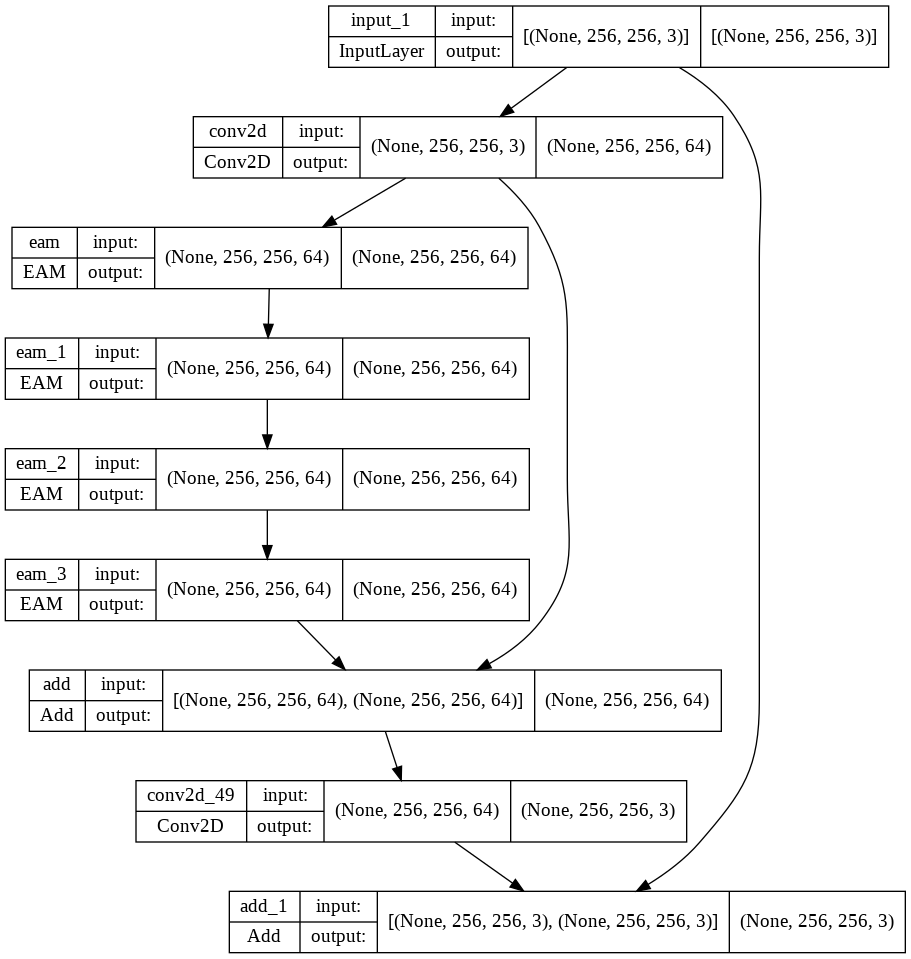

In [46]:
from keras.utils.vis_utils import plot_model

plot_model(RIDNet, to_file='RIDNet.png', show_shapes=True, show_layer_names=True)

In [47]:
import numpy as np
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]
        
        return tuple((batch_x,batch_y))
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            
batch_size=32

In [48]:
import PIL
import cv2 
import random

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


def noise_add(image):
  image = cv2.GaussianBlur(np.array(image), (5, 5), 0)
  uni_noise=np.zeros(image.shape,dtype=np.uint8)
  cv2.randu(uni_noise,0,255)
  uni_noise=(uni_noise*0.5).astype(np.uint8)
  un_img=cv2.add(image,uni_noise)
  return un_img

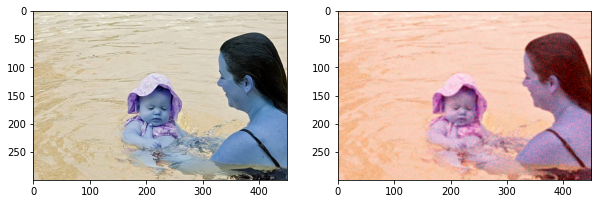

In [49]:
X = cv2.imread('/content/dataset/images/image_10.jpg')
XP = noise_add(X)

import matplotlib.pyplot as plt

def plot_data(x,y):
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
    ax[0].imshow(x)
    ax[1].imshow(y)

plot_data(X,XP)

In [50]:
import glob
kl = glob.glob('/content/dataset/images/*')
x_train,x_test = train_test_split(kl,random_state=50,test_size=0.3)

In [51]:
from tqdm.notebook import tqdm
X_train_patches = []
y_train_patches = []
for i in tqdm(x_train):
  path = i#X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_train images
  patches_nsy = patches(img_nsy,256)
  
  #path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_train images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(noise_add(patches_gt[j][k][0]))
  
X_train = np.array(X_train_patches)
Y_train = np.array(y_train_patches)

  0%|          | 0/65 [00:00<?, ?it/s]

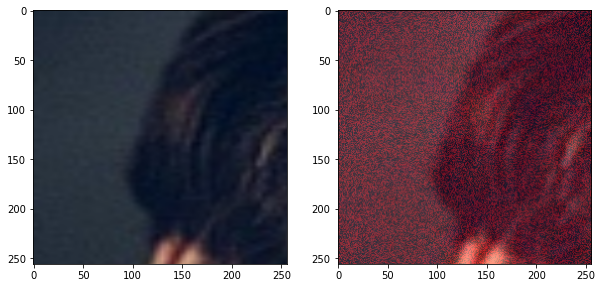

In [52]:
plot_data(X_train[0],Y_train[0])

In [53]:
X_test_patches = []
y_test_patches = []
for i in tqdm(x_test):
  path =i# X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_test images
  patches_nsy = patches(img_nsy,256)
  
  #path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_test images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(noise_add(patches_gt[j][k][0]))

X_test = np.array(X_test_patches)
Y_test = np.array(y_test_patches)

  0%|          | 0/28 [00:00<?, ?it/s]

In [54]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1040, 256, 256, 3)
(1040, 256, 256, 3)
(448, 256, 256, 3)
(448, 256, 256, 3)


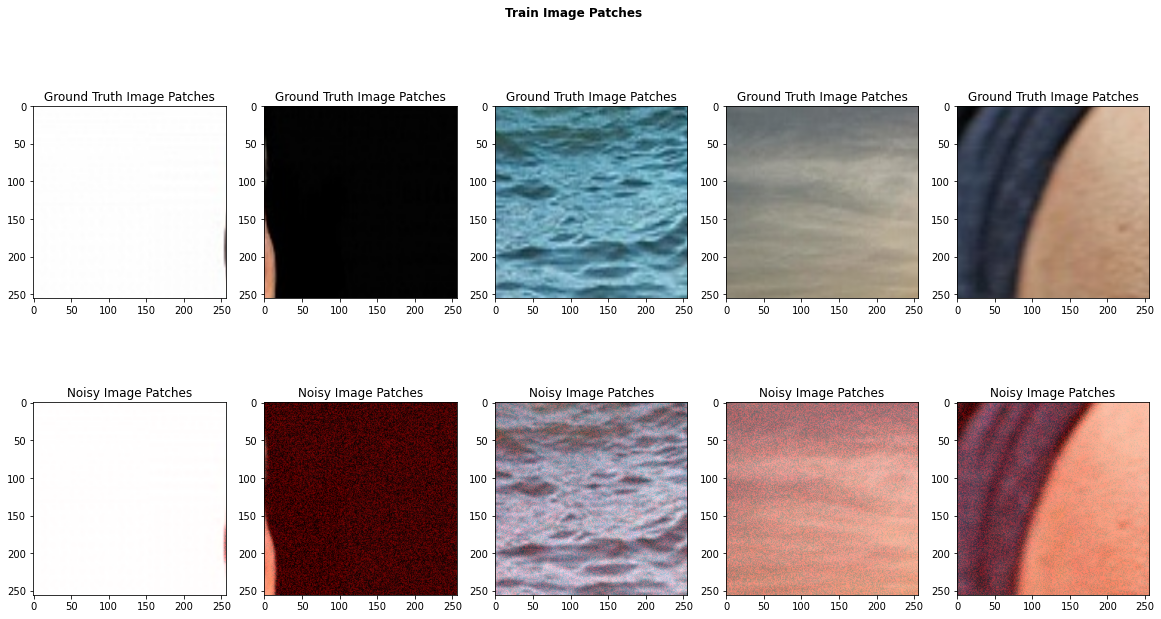

In [55]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, len(X_train)), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(X_train[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(Y_train[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

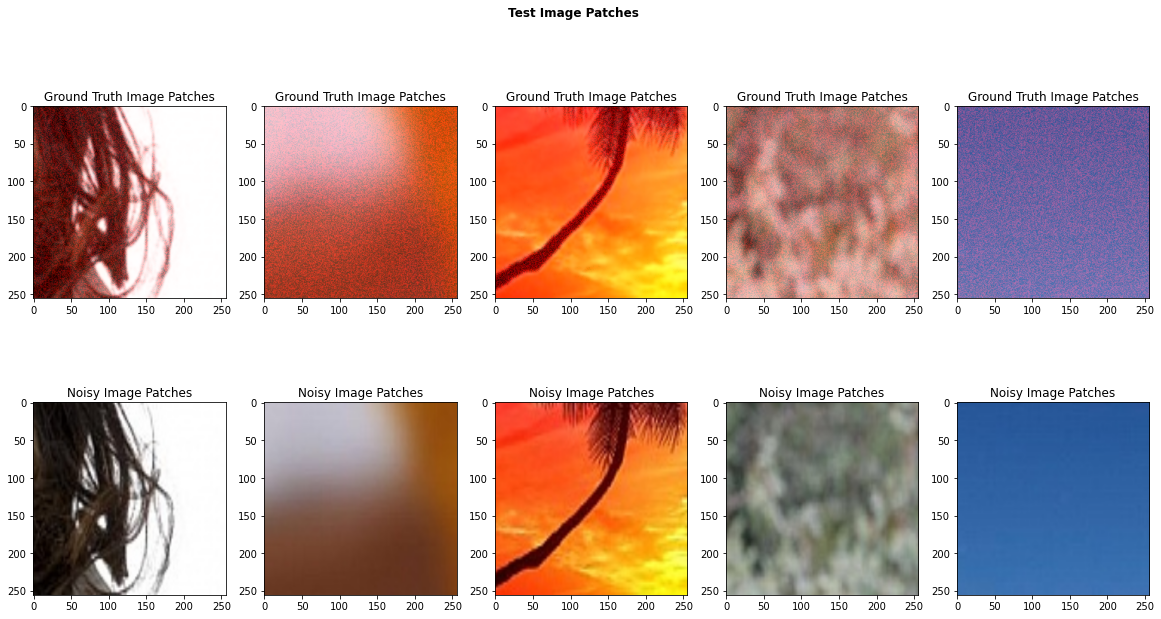

In [56]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, len(Y_test)), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(Y_test[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [57]:
print("Total number of image patches on train data : ", len(X_train))
print("Total number of image patches on test data : ", len(X_test))

Total number of image patches on train data :  1040
Total number of image patches on test data :  448


In [58]:
X_train_patches = X_train.astype("float32") / 255.0
y_train_patches = Y_train.astype("float32") / 255.0
X_test_patches = X_test.astype("float32") / 255.0
y_test_patches = Y_test.astype("float32") / 255.0

In [59]:
batch_size=8
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True) 

In [60]:
from livelossplot import PlotLossesKeras

In [61]:
log_dir="logs/model_4"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=4,min_delta=0.00001)
callback = [tensorboard,reducelr]
RIDNet.fit(train_dataloader,shuffle=True,epochs=20,validation_data= test_dataloader)

Epoch 1/20
130/130 [==============================] - 238s 2s/step - loss: 0.2306 - val_loss: 0.0099
Epoch 2/20
130/130 [==============================] - 236s 2s/step - loss: 0.0058 - val_loss: 0.0044
Epoch 3/20
130/130 [==============================] - 236s 2s/step - loss: 0.0053 - val_loss: 0.0049
Epoch 4/20
130/130 [==============================] - 236s 2s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 5/20
130/130 [==============================] - 236s 2s/step - loss: 0.0051 - val_loss: 0.0042
Epoch 6/20
130/130 [==============================] - 237s 2s/step - loss: 0.0047 - val_loss: 0.0041
Epoch 7/20
130/130 [==============================] - 237s 2s/step - loss: 0.0050 - val_loss: 0.0041
Epoch 8/20
130/130 [==============================] - 236s 2s/step - loss: 0.0049 - val_loss: 0.0041
Epoch 9/20
130/130 [==============================] - 236s 2s/step - loss: 0.0047 - val_loss: 0.0039
Epoch 10/20
130/130 [==============================] - 236s 2s/step - loss: 0.0049 - val_lo

In [62]:
RIDNet.save('RIDNet.h5')

In [63]:
RIDNet.save("RIDNet.json")

In [ ]:
%tensorboard --logdir "/content/logs/model_4"

In [65]:
RIDNet = tf.keras.models.load_model('/content/RIDNet.h5',custom_objects={'EAM':EAM})

In [66]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(RIDNet)
tflite_RIDNet = tf_lite_converter.convert()

In [67]:
open('RIDNet.tflite', "wb").write(tflite_RIDNet)

7209204

In [68]:
tflite_RIDNet = tf.lite.Interpreter(model_path = '/content/RIDNet.tflite')
tflite_RIDNet.allocate_tensors()
input_details = tflite_RIDNet.get_input_details()
output_details = tflite_RIDNet.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 256 256   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 256 256   3]
Output Type: <class 'numpy.float32'>


In [69]:
def prediction_tflite(img,model):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(1024,1024))
  img = img.astype("float32") / 255.0

  img_patches = patches(img,256)

  nsy=[]
  for i in range(4):
    for j in range(4):
      nsy.append(img_patches[i][j][0])
  nsy = np.array(nsy)
  pred=[]
  for patch in nsy:
    model.set_tensor(input_details[0]['index'], tf.expand_dims(patch,axis=0))
    model.invoke()
    tflite_model_predictions = model.get_tensor(output_details[0]['index'])
    pred.append(tflite_model_predictions)

  pred_img = np.reshape(pred,(4,4,1,256,256,3))
  pred_img = unpatchify(pred_img, img.shape)
  return pred_img

In [74]:

img = cv2.imread("/content/dataset/images/image_103.jpg")

In [75]:
out= prediction_tflite(img,tflite_RIDNet)

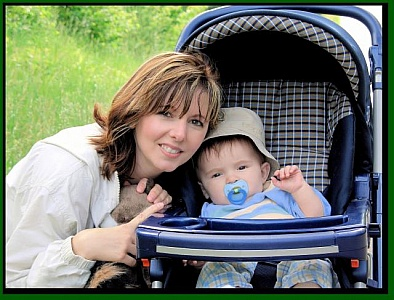

In [77]:
cv2_imshow(img)

In [82]:
cv2.imwrite('/content/out.png',out)

True